#  Contexte

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.  

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).  

**Notes:**  
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.  

**Attribute Information:**  
1.date: Date in format dd/mm/yyyy  
2.time: time in format hh:mm:ss  
3.globalactivepower: household global minute-averaged active power (in kilowatt)  
4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)  
5.voltage: minute-averaged voltage (in volt)  
6.global_intensity: household global minute-averaged current intensity (in ampere)  
7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. 

In [35]:
# data = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
# train = []
# target = []
# for i in range(7,len(data)):
#     train.append(data[i-7:i])
#     target.append(data[i])

In [36]:
# print(np.array(train).shape)
# print('----------------')
# print(target)

## Import library

In [37]:
import pandas as pd
import numpy as np

# Loading date wrangling package
from datetime import datetime

#evaluation metric
from sklearn.metrics import mean_squared_error

# univariate multi-step lstm
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM

# univariate multi-step encoder-decoder lstm
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

#plot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load data

In [38]:
# load all data
# dataset = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [39]:
# Reading the input data
d = pd.read_csv('data/household_power_consumption.csv')

In [40]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   datetime               object 
 1   Global_active_power    float64
 2   Global_reactive_power  float64
 3   Voltage                float64
 4   Global_intensity       float64
 5   Sub_metering_1         float64
 6   Sub_metering_2         float64
 7   Sub_metering_3         float64
 8   sub_metering_4         float64
dtypes: float64(8), object(1)
memory usage: 142.5+ MB


## Preprocessing

In [41]:
# Formating to datetime
d['datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['datetime']]

In [42]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
 8   sub_metering_4         float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 142.5 MB


In [43]:
# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('datetime', as_index=False)['Global_active_power'].mean()

# Sorting the values
d.sort_values('datetime', inplace=True)

In [44]:
d

,datetime,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
2075254,2010-11-26 20:58:00,0.946
2075255,2010-11-26 20:59:00,0.944
2075256,2010-11-26 21:00:00,0.938
2075257,2010-11-26 21:01:00,0.934


## Test code for creat lag

In [45]:
ts = [1621.0, 1536.0, 1500.0, 1434.0, 1489.0, 1620.0]

In [46]:
X = [
[1621.0, 1536.0, 1500.0], # First three lags
[1536.0, 1500.0, 1434.0], # Second three lags
[1500.0, 1434.0, 1489.0], # Third three lags
]
Y = [1434.0, 1489.0, 1620.0]

In [47]:
#def create_X_Y(ts: list, lag: int) -> tuple:
#    """
#    A method to create X and Y matrix from a time series list for the training of 
#    deep learning models 
#    """
lag=6

X, Y = [], []

if len(ts) - lag <= 0:
    X.append(ts)
else:
    for i in range(len(ts) - lag):
        Y.append(ts[i + lag])
        X.append(ts[i:(i + lag)])
    
X, Y = np.array(X), np.array(Y)
print(X)
# Reshaping the X array to an LSTM input shape 
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X)

[[1621. 1536. 1500. 1434. 1489. 1620.]]
[[[1621.]
  [1536.]
  [1500.]
  [1434.]
  [1489.]
  [1620.]]]


## Code refactoring

In [49]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        global X_train
        global X_test
        global Y_train
        global Y_test
        
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()
        
        # Defining the number of neurons in the LSTM layer
        n_layer = 50
        # Defining how many lags will be used in the time series
        n_lag = 3
        
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse', metrics='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat

## Initiating the model

In [50]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'Global_active_power',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

## Fitting model

In [51]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
6891/6891 [==============================] - 69s 10ms/step - loss: 0.0879 - mse: 0.0879 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 2/10
6891/6891 [==============================] - 66s 10ms/step - loss: 0.0715 - mse: 0.0715 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 3/10
6891/6891 [==============================] - 63s 9ms/step - loss: 0.0716 - mse: 0.0716 - val_loss: 0.0459 - val_mse: 0.0459
Epoch 4/10
6891/6891 [==============================] - 63s 9ms/step - loss: 0.0689 - mse: 0.0689 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 5/10
6891/6891 [==============================] - 63s 9ms/step - loss: 0.0674 - mse: 0.0674 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 6/10
6891/6891 [==============================] - 63s 9ms/step - loss: 0.0664 - mse: 0.0664 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 7/10
6891/6891 [==============================] - 67s 10ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 8/10
6891/6891 [==============================

## Plot the predict's results

In [52]:
def validation_curve(model):

    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.axis([0,10,0,0.3])
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.show()

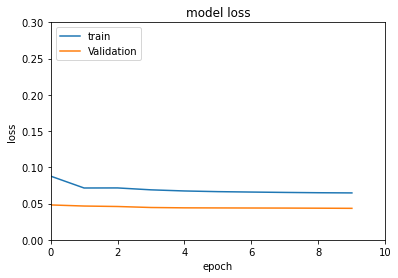

In [53]:
validation_curve(model.history)

In [54]:
def mse_curve(model):

    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.axis([0,10,0,0.3])
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.show()

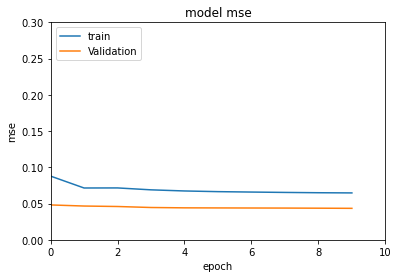

In [55]:
mse_curve(model.history)

In [56]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
print(r2_score(Y_test,y_pred))

0.9411524267880352


In [57]:
yhat = deep_learner.predict()

In [58]:
yhat

[0.3401587,
 0.355155,
 0.8558657,
 0.5026431,
 0.549709,
 0.529004,
 0.5211437,
 0.50360477,
 1.1678988,
 1.3097209,
 0.43284073,
 0.58554554,
 0.5739678,
 0.5804993,
 0.6035564,
 0.5323908,
 0.51020724,
 0.51158035,
 0.52074873,
 0.8272977,
 0.6926379,
 0.6224928,
 0.5566144,
 0.5146661,
 0.5179568,
 0.50395113,
 0.45307478,
 0.45532408,
 0.43852612,
 0.44353878,
 0.66633916,
 0.61844933,
 1.9500932,
 2.2375162,
 2.2367988,
 1.8565519,
 1.0153148,
 0.51005197,
 1.8921031,
 1.7060999,
 1.8724736,
 1.9528049,
 2.1529584,
 1.6623894,
 1.5518535,
 1.4699026,
 1.5130602,
 1.5310384,
 2.671014,
 3.2436843,
 3.2120264,
 2.3927033,
 2.8765616,
 3.395584,
 3.4014745,
 3.4615395,
 3.0343375,
 3.43432,
 2.3199503,
 2.417175,
 3.171279,
 3.1988633,
 3.075899,
 2.6502726,
 2.6071289,
 2.434139,
 2.4254415,
 2.4086604,
 2.3612287,
 2.305609,
 2.2679305,
 2.2880042,
 2.2258832,
 2.1827075,
 2.254688,
 2.1610389,
 2.2780712,
 2.2224154,
 2.2415857,
 2.2682593,
 2.2054455,
 2.2225268,
 2.2501295,
 2.

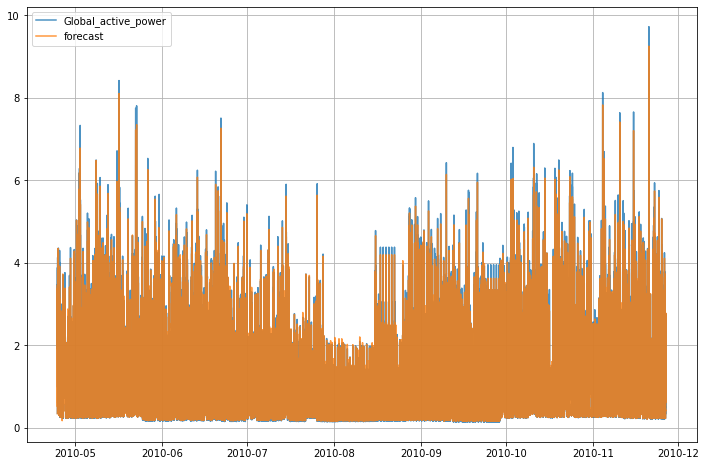

In [59]:
# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Global_active_power', 'forecast']:
  plt.plot(
    'datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

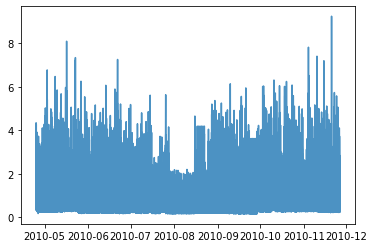

In [60]:
plt.plot(
    'datetime',
    "forecast",
    data=fc,
    label=dtype,
    alpha=0.8
  )

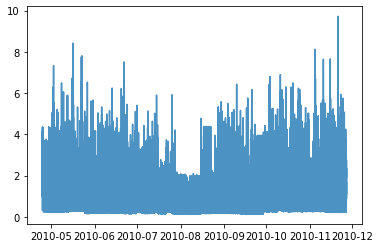

In [61]:
plt.plot(
    'datetime',
    "Global_active_power",
    data=fc,
    label=dtype,
    alpha=0.8
  )

## Save the model

In [62]:
from tensorflow.keras.models import save_model, load_model

# ##### ##### ##### SAVE MODEL JUST ONE TIME ##### ##### #####
save_model(model,'model.h5')